# PYTORCH MODEL

## Preprocessing the Data

### loading the data
- cifar10: 
    - was loaded from a folder online
    - is a dataset for image classification
    - included in the tensorflow.keras.datasets module
    - is imported from data.py, it outputs training and testing data partitions (x_train, y_train, x_test, and y_test)
- to note:
    - when i decided on using cifar10 as my dataset, i tried to upload them from keras/tensorflow and pytorch, but was unsuccessful due to issues with library verisons.
    - in order to combat this, i manually downloaded the data from online and processed it via the script in data.py.

In [54]:
from data import load_cifar10

root_dir = "//Users//yanajakhwal//Desktop//Projects//img_classification//cifar10_data//cifar-10-batches-py"
x_train, y_train, x_test, y_test = load_cifar10(root_dir)

### the shapes of the dataset splits
- ___.shape => __ images of size __ by __ with __ colour channels 
    - 3 is RBG
- ___.shape => __ labels corresponsiding to the training images

In [55]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# should print:
#     Training data shape: (50000, 32, 32, 3)
#     Training labels shape: (50000,)
#     Test data shape: (10000, 32, 32, 3)
#     Test labels shape: (10000,)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


### preprocessing the data
- why normalize:
    - pixels range from [0,255] for the RGB channels-- so dividing by 255 scales to a range of [0,1].
        - this is done to ensure that the inputs the the neural network are uniform
        - avoids the domination of features due to their larger numerical values
    - performance increases
        - leads to reducing the number of epochs (iterations) required
        - consistency with the numerical data
    - improves convergence speed of gradient descent. 
        - the gradient descent algorithm minimizes the loss function of the model
        - the loss function measures how far off the model's predictions are from the target values 

In [56]:
# normalizing the pixel values of images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### rearrange dimensions and converting the data to PyTorch tensors
- permuting due to the rquired format of pytorch models
    - changes the order of the dimensions of the tensor
    - cifar_10's dimesions are (batch_size, channels, height, width) and then permute changes it to: (batch_size, height, width, channels)

In [57]:
import torch

x_train = torch.tensor(x_train).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test)

print(x_train.shape)  # (batch_size, 3, 32, 32)
print(x_test.shape)   # (batch_size, 3, 32, 32)

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


### convert the data to PyTorch tensors
- TensorDataset class wraps the data splits into a dataset object
    - it allows the data to be indexed like a regular python list where each element in the dataset is a tupple
        - (input_tensor, target_tensor) input is the image and the target is the corresponsing label
- 64 is the number of samples loaded per batch with their label
    - loading data in batches rather than all at once reduces memory usage and allows for efficient training, especially with large datasets
    - DataLoader handles the complexity of shuffling and batching -- making model training and evaluation more efficient.
- shuffling the data at the beginning of epoch encourages better generalization for the train_loader
- shouldn't suffle the test_loader as evaluation is performed on the data consistently


In [58]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### visualizing the images
- the training data that was augmented can now be visualized 

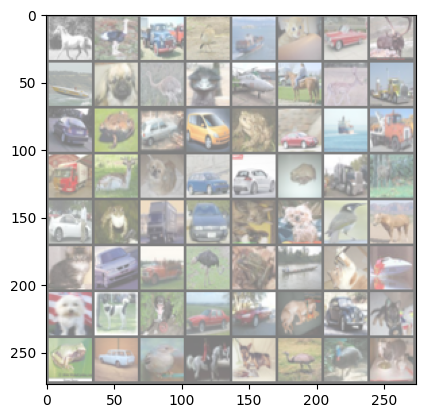

Labels: 7 2 9 2 8 3 1 4


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary (here just convert from [-1, 1] to [0, 1])
    npimg = img.numpy()  # Convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(8)))

## Building a convolutional neural network (CNN) for image classification utilizing pytorch

### model architecture
- why use a CNN?
    - a CNN is a neural network designed for processing structured grid-like-data (like images).
    - they utilize convulutional layers that apply filters (kernels) to local regions of the input image.
         - effeciently capture features like edges (lower layers)
         - more complex detetct patterns like shapes or entire objects (higher layers)
         - using different levels of learn features (lower to higher layers) mimicks the human process of precieving visual information
    - the same filter is applied to different parts of the image and so teh network will lern a set of filters which can detect features anywhere in the image.
        - this reduced the number of parameters in the network compared to the fully connected layers of traditional neural networks
        - so CNNs are more efficient and less prone to overfitting (especially when dealing with large images)
    - benefits of translation invariance:
        - CNNs use pooling layers (ex: max pooling), which downsample the feature maps, the network becomes less sensitive to the exact location of features in the image.
        - allows CNNs to recognize objects in images regardless of where they appear. For instance, a CNN trained to recognize a cat will be able to identify the cat whether it’s in the center or in the corner of the image
    - well-suited for large sets of image based data sets.



In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### building the model
- convolutional layer:
    - 32 filters (kernels) with the filter size of 3x3 pixels
        - with each layer the filter double to capture more complex patterns and features
    - 'relu' is a rectified linear unit which converts negative pixel values to 0.
    - shape of input is 32x32 pixed with 3 colour channels (RGB) for the first layer
- pooling layers:
    - downsamples the feature maps by taking the maximum value in each 2x2 region 
        - reduced the spatial dimesion by half (ex: 32x32 => 16x16) which reduced numbers of parameters and compuations in the network also provides translation invariance
- flattening layer:
    - converts the three-dimensional output into a one-dimensional vector (i.e: flattening)
    - the vector length is calculated using the previous layers' product (ex: 32 x 64 x 128)
- dropout layer:
    - depneding on the input it will randomly set a percentage of the input units to 0
    - prevents overfitting which ensures a lack of reliancy on single features or subsets of features

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # first convolutional layer /// 32 filters, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        # first pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        # second convolutional layer /// 64 filters, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 filters, 3x3 kernel
        # third convolutional layer /// 128 filters, 3x3 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 filters, 3x3 kernel
        # connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # adjusted for the flattened size after 3 pooling layers
        self.dropout = nn.Dropout(0.5)  # dropout layer
        self.fc2 = nn.Linear(128, 10)  # output layer with 10 classes
        
    def forward(self, x):
        # apply first convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # apply second convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # apply third convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv3(x)))
        # flatten the tensor to feed into fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        # apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        # apply dropout to prevent overfitting
        x = self.dropout(x)
        # apply the final fully connected layer (output layer)
        x = self.fc2(x)
        return x

# Create an instance of the model
net = Net()

# defining a loss function and optimizer

## defining a loss
- loss = 'categorical_crossentropy':
    - loss is the calculation of the variance between the model's predictions and the actual outputs
    - compares the predicted probability distribution over the classes (from the softmax output layer) to the true distribution (one-hot encoded labels).
        - the loss is higher when the predicted probability for the correct class is low
    categorical crossentropy encorages the model to putput higher probabilities for the correct class and the opposite

In [62]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

### defining an optimizer
- an algorithm that updates the weights of the neural network
    - minimizes the loss function
- Adam is commonly used for opimization with deep learning
    - combines the best properties of two other optimizers AdaGrad (good for sparse gradients) and RMSProp (good for non-stationary settings)

In [63]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

### initialize tensorboard writer and log the model graph

In [64]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/experiment_name')
dummy_input = torch.randn(1, 3, 32, 32)
writer.add_graph(net, dummy_input)

### define the data augmentation transformations

In [65]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Training the model

### function for data augmentation

- why use data augmentation:
    - increases the dataset's (each epoch's batch) diversity with modified versions of images.
    - the transforms class provides image transformations like rotation, flipping, and cropping to the tensors
    - creates a list of the transformed images to form a batch of tensors

In [66]:
import torchvision.transforms as transforms
import torch

def apply_transformations(images, transform):
    augmented_images = []
    for img in images:
        img = transforms.ToPILImage()(img)
        img = transform(img)
        augmented_images.append(img)
    return torch.stack(augmented_images)

### performing one complete epoch/pass over the entire training batches of the dataset
- intializing for the current epoch:
    - running_loss accumulates total loss 
    - correct_train tracks number of correct preductions made by the model
    - keeps track of number of training examples
- utilizes the apply_transformations function for data augmentation
- clears the gradients the model parameters
    - since gradients are accumulated in PyTorch, they must be zeroed out to avoid accumulating 
    gradients form previous batches
- backpropegate the loss and updates model's parameters
    - computes the gradients of the loss with respect to the model's parameters using backpropogation 
    - the gradient of a loss function WRT a parameter tells us the ROC of the loss function as a parameter changes
- the model's parameters are then updated using the gradients computed with the backpropogation
- finally calulates the epoch-level metrics 
- caluclating training accuracy:
    - running_loss is accumulated
    - torch.max(outputs.data, 1) determines the predicted class for each image batch 
        - done by selecting the class with the highest probability and is added to predicted 
    - total_train is updated with the number of processed training examples by the the size of the batch
    - the accumualtion of corrcect_train updates based on how many predictions were correct
- finally the train_accuracy and train_loss are computed as percentages

In [67]:
def train_one_epoch(net, train_loader, optimizer, criterion, transform_train):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = apply_transformations(inputs, transform_train)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    return train_loss, train_accuracy

### function that evaluates the performance of the neural network on a validation set over one epoch
- doesn't update teh model's parameters, just checks how the model performs on unseen data
- intializing for the current epoch:
    - running_val_loss accumulates the total loss across every validation epoch
    - correct_val tracks the nuumber of correct predictions made by the model
    - total_val tracks the number of validation examples processed in the current epoch
- the model is then put into evaluation mode
    - this is due to layers like dropout and batch normalization behave differently during training and evaluation
    - ex: the dropout is disabled during evaluation to ensure consistent predictions
- gradient calculation is disabled in order to reduce memory usage and computation speed
- the iterations over the batches of validation data (from test_loader):
    - unpacks the batch into images (the validation inputs) and labels (the true labels)
    - feeds the input images through the network to generate predictions (outputs)
    - computes the loss between the model’s predictions (outputs) and the true labels (labels) using the specified loss function (criterion)
    - the loss for the epoch is then accumulated
- caluclating training accuracy:
    - running_loss is accumulated
    - torch.max(outputs.data, 1) determines the predicted class for each image batch 
        - done by selecting the class with the highest probability and is added to predicted 
    - total_train is updated with the number of processed training examples by the the size of the batch
    - the accumualtion of corrcect_train updates based on how many predictions were correct
- finally the train_accuracy and train_loss are computed as percentages

In [68]:
def validate_one_epoch(net, test_loader, criterion):
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_loss = running_val_loss / len(test_loader)
    
    return val_loss, val_accuracy

### function for visualizing training and validation accuracy

In [69]:
def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


### data augmentating and normalizating
- randomly flips, crops, adds padding, rotates up to 15 degress, and converts the image to a PyTorch tensor
- image is the normalized

In [70]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

writer = SummaryWriter('runs/cifar10_experiment')
# Log the model graph
dummy_input = torch.randn(1, 3, 32, 32)  # Example input tensor
writer.add_graph(net, dummy_input)

# Define the data augmentation transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### the main loop for training and validation the neural network over 50 epochs
- list are initialized to store accuracy and loss values
    - they are updated with helper functions
- prints the epoch statistics

In [71]:
# Training loop
num_epochs = 50

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(net, train_loader, optimizer, criterion, transform_train)
    val_loss, val_accuracy = validate_one_epoch(net, test_loader, criterion)
    
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    # logs metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    
    # prints statistics for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Epoch [1/50], Train Loss: 1.757, Train Accuracy: 34.88%, Validation Loss: 2.661, Validation Accuracy: 22.31%
Epoch [2/50], Train Loss: 1.457, Train Accuracy: 47.49%, Validation Loss: 2.032, Validation Accuracy: 27.79%
Epoch [3/50], Train Loss: 1.316, Train Accuracy: 52.98%, Validation Loss: 2.139, Validation Accuracy: 30.67%
Epoch [4/50], Train Loss: 1.227, Train Accuracy: 56.36%, Validation Loss: 1.925, Validation Accuracy: 32.03%
Epoch [5/50], Train Loss: 1.161, Train Accuracy: 58.77%, Validation Loss: 1.585, Validation Accuracy: 43.01%
Epoch [6/50], Train Loss: 1.101, Train Accuracy: 61.75%, Validation Loss: 1.849, Validation Accuracy: 34.55%
Epoch [7/50], Train Loss: 1.062, Train Accuracy: 62.95%, Validation Loss: 1.800, Validation Accuracy: 36.36%
Epoch [8/50], Train Loss: 1.031, Train Accuracy: 64.28%, Validation Loss: 1.749, Validation Accuracy: 41.71%
Epoch [9/50], Train Loss: 0.992, Train Accuracy: 65.84%, Validation Loss: 1.796, Validation Accuracy: 38.49%
Epoch [10/50], Trai

### save the model

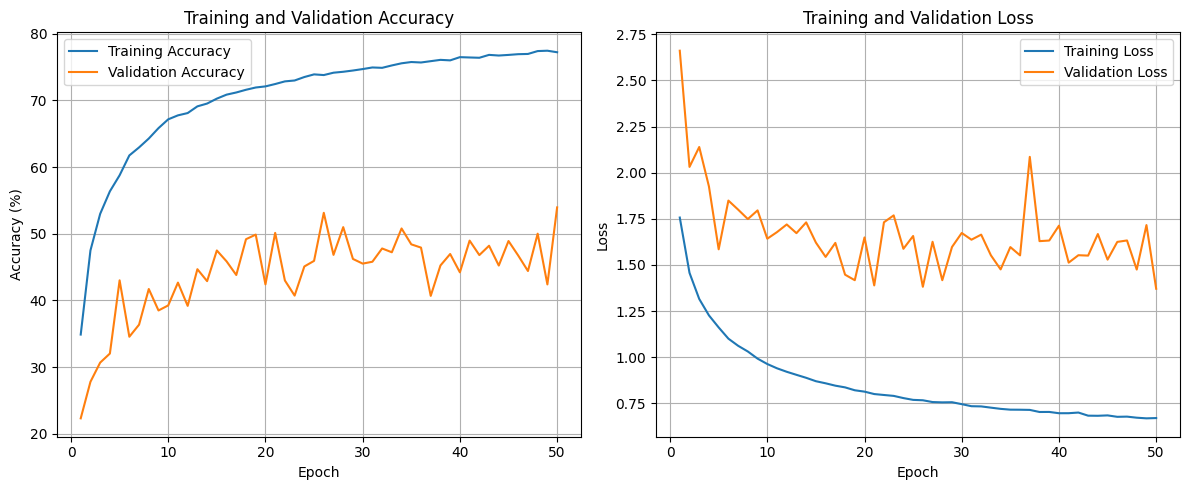

In [72]:
torch.save(net.state_dict(), 'cifar10_cnn_model_pytorch.pth')
writer.close()

# plots the training and validation metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)